In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

--2022-07-12 11:02:43--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘daily-min-temperatures.csv.1’

daily-min-temperatu 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2022-07-12 11:02:44 (3.14 MB/s) - ‘daily-min-temperatures.csv.1’ saved [67921/67921]



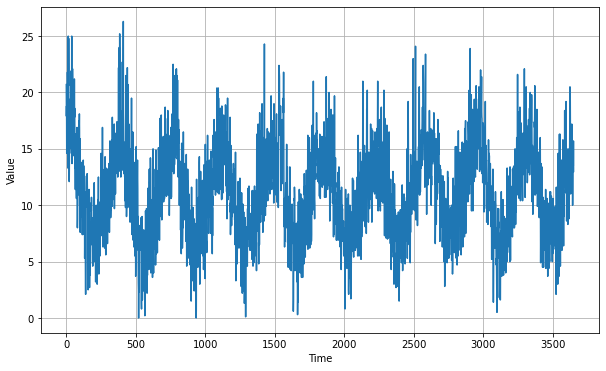

In [6]:
import csv
time_step = []
temps = []

with open('./daily-min-temperatures.csv') as csvfile:
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 311ms/step - loss: 31.1571 - mae: 31.6550 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 3s 274ms/step - loss: 30.5778 - mae: 31.0756 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 3s 313ms/step - loss: 29.6825 - mae: 30.1801 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 4s 396ms/step - loss: 28.5613 - mae: 29.0586 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 4s 371ms/step - loss: 27.1974 - mae: 27.6945 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 4s 365ms/step - loss: 25.5017 - mae: 25.9986 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 4s 356ms/step - loss: 23.3464 - mae: 23.8429 - lr: 1.9953e-08
Epoch 8/100
10/10 [========

10/10 [==============================] - 6s 575ms/step - loss: 15.4296 - mae: 15.9222 - lr: 3.1623e-05
Epoch 72/100
10/10 [==============================] - 6s 567ms/step - loss: 8.9367 - mae: 9.4270 - lr: 3.5481e-05
Epoch 73/100
10/10 [==============================] - 6s 590ms/step - loss: 6.5998 - mae: 7.0886 - lr: 3.9811e-05
Epoch 74/100
10/10 [==============================] - 6s 578ms/step - loss: 4.2766 - mae: 4.7554 - lr: 4.4668e-05
Epoch 75/100
10/10 [==============================] - 5s 527ms/step - loss: 3.4240 - mae: 3.8971 - lr: 5.0119e-05
Epoch 76/100
10/10 [==============================] - 6s 532ms/step - loss: 2.9702 - mae: 3.4401 - lr: 5.6234e-05
Epoch 77/100
10/10 [==============================] - 6s 548ms/step - loss: 2.9618 - mae: 3.4312 - lr: 6.3096e-05
Epoch 78/100
10/10 [==============================] - 5s 439ms/step - loss: 2.9362 - mae: 3.4064 - lr: 7.0795e-05
Epoch 79/100
10/10 [==============================] - 4s 401ms/step - loss: 2.8187 - mae: 3.2870 - 

(1e-08, 0.0001, 0.0, 60.0)

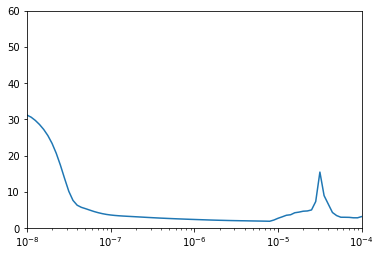

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 8s 190ms/step - loss: 9.9820 - mae: 10.4700
Epoch 2/150
25/25 [==============================] - 3s 132ms/step - loss: 2.5295 - mae: 2.9922
Epoch 3/150
25/25 [==============================] - 3s 129ms/step - loss: 1.9501 - mae: 2.4046
Epoch 4/150
25/25 [==============================] - 3s 131ms/step - loss: 1.8618 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 4s 157ms/step - loss: 1.8214 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 4s 155ms/step - loss: 1.7908 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 4s 143ms/step - loss: 1.7685 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 4s 153ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 4s 139ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 4s 143ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/150
25/25 [==================

25/25 [==============================] - 4s 145ms/step - loss: 1.5069 - mae: 1.9484
Epoch 86/150
25/25 [==============================] - 4s 167ms/step - loss: 1.5060 - mae: 1.9475
Epoch 87/150
25/25 [==============================] - 4s 171ms/step - loss: 1.5074 - mae: 1.9489
Epoch 88/150
25/25 [==============================] - 4s 173ms/step - loss: 1.5053 - mae: 1.9467
Epoch 89/150
25/25 [==============================] - 4s 157ms/step - loss: 1.5050 - mae: 1.9463
Epoch 90/150
25/25 [==============================] - 4s 156ms/step - loss: 1.5064 - mae: 1.9479
Epoch 91/150
25/25 [==============================] - 4s 157ms/step - loss: 1.5055 - mae: 1.9468
Epoch 92/150
25/25 [==============================] - 4s 158ms/step - loss: 1.5045 - mae: 1.9459
Epoch 93/150
25/25 [==============================] - 4s 157ms/step - loss: 1.5032 - mae: 1.9445
Epoch 94/150
25/25 [==============================] - 4s 165ms/step - loss: 1.5023 - mae: 1.9437
Epoch 95/150
25/25 [=======================

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


113/113 [==============================] - 3s 21ms/step


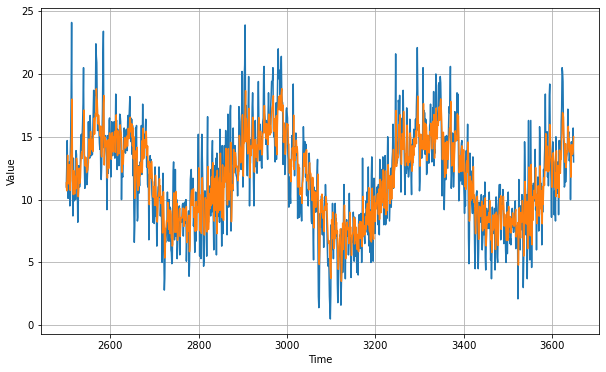

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796131

In [16]:
print(rnn_forecast)

[11.329465  10.705592  12.125084  ... 13.60471   13.7969885 15.009518 ]
